## Stage 3 - Full Script for HPC to run 

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import torch.nn.init as init
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Initialize scalars outside the dataset class
length_scaler = StandardScaler()
cptu_scaler = StandardScaler()
output_scaler = StandardScaler()


class BoreholeDataset(Dataset):
    def __init__(self, csv_file, length_scaler, cptu_scaler, output_scaler, fit_scalers=True):
        # Load the data
        data = pd.read_csv(csv_file)

        # Extracting Length, CPTu, and Output columns
        self.RBC = data.iloc[:, 0].values.reshape(-1, 1)
        self.cptu_data = data.iloc[:, 1:6163].values
        self.outputs = data.iloc[:, 6163].values.reshape(-1, 1)

        # Scale the data if required
        if fit_scalers:
            self.RBC = length_scaler.fit_transform(self.RBC)
            self.cptu_data = cptu_scaler.fit_transform(self.cptu_data)
            self.outputs = output_scaler.fit_transform(self.outputs)
        else:
            self.RBC = length_scaler.transform(self.RBC)
            self.cptu_data = cptu_scaler.transform(self.cptu_data)
            self.outputs = output_scaler.transform(self.outputs)

        # Convert numpy arrays to tensors
        self.RBC = torch.tensor(self.RBC, dtype=torch.float32)
        self.cptu_data = torch.tensor(self.cptu_data, dtype=torch.float32)
        self.outputs = torch.tensor(self.outputs, dtype=torch.float32)

    def __len__(self):
        return len(self.outputs)

    def __getitem__(self, idx):
        # Returning tensors that will be automatically sent to the device during the batch gathering by the DataLoader
        return self.RBC[idx], self.cptu_data[idx], self.outputs[idx]


# Prepare datasets and loaders
train_dataset = BoreholeDataset('Stage_3_traind_merged_reduced.csv', length_scaler, cptu_scaler, output_scaler,
                                fit_scalers=True)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = BoreholeDataset('Stage_3_vald_merged_reduced.csv', length_scaler, cptu_scaler, output_scaler, fit_scalers=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)






import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class TwoBranchMLP(nn.Module):
    def __init__(self, length_features, cptu_features, length_neurons, cptu_neurons, dropout_rate=0.5):
        super(TwoBranchMLP, self).__init__()

        # Dynamically create layers for the CPTu branch
        self.cptu_branch = self.create_branch(cptu_features, cptu_neurons, dropout_rate)

        # Dynamically create layers for the Length branch
        self.length_branch = self.create_branch(length_features, length_neurons, dropout_rate)

        # Combine outputs from both branches
        combined_neurons = cptu_neurons[-1] + length_neurons[-1]
        self.combined = nn.Sequential(
            nn.Linear(combined_neurons, max(cptu_neurons[-1], length_neurons[-1])),
            nn.BatchNorm1d(max(cptu_neurons[-1], length_neurons[-1])),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(max(cptu_neurons[-1], length_neurons[-1]), 1)
        )

    def create_branch(self, input_features, neurons, dropout_rate):
        layers = [nn.Linear(input_features, neurons[0])]
        for i in range(1, len(neurons)):
            layers.extend([
                nn.BatchNorm1d(neurons[i-1]),
                nn.LeakyReLU(negative_slope=0.01),
                nn.Dropout(dropout_rate),
                nn.Linear(neurons[i-1], neurons[i])
            ])
        return nn.Sequential(*layers)

    def forward(self, length_data, cptu_data):
        length_out = self.length_branch(length_data)
        cptu_out = self.cptu_branch(cptu_data)
        combined_in = torch.cat((length_out, cptu_out), dim=1)
        return self.combined(combined_in)


def initialize_weights(m):
    if isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)


# Example of how to initialize the model with different neurons configuration
length_neurons = [32, 32, 32]  # Adjusted to match your Length data features
cptu_neurons = [32, 32, 32]  # Adjusted to match your CPTu data features
model = TwoBranchMLP(1, 6162, length_neurons, cptu_neurons, 0.1)
model.apply(initialize_weights)



# Example setup for the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

    model.train()
    loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        for batch_idx, (length_data, cptu_data, targets) in enumerate(train_loader):

            optimizer.zero_grad()
            outputs = model(length_data, cptu_data)
            loss = criterion(outputs, targets.view_as(outputs))
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
        
        average_train_loss = total_train_loss / len(train_loader)
        loss_history.append(average_train_loss)

        # Validation Phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for length_data, cptu_data, targets in val_loader:

                outputs = model(length_data, cptu_data)
                val_loss = criterion(outputs, targets.view_as(outputs))
                total_val_loss += val_loss.item()

        average_val_loss = total_val_loss / len(val_loader)
        val_loss_history.append(average_val_loss)
        
        scheduler.step(average_val_loss)
    return loss_history, val_loss_history



loss_history1 = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=1)
print(loss_history1)

# torch.save(model.state_dict(), "S3_model1.pth")
# 
# with open('S3_loss1.txt', 'w') as file:
#     for item in loss_history1:
#         file.write(f"{item}\n")

# from joblib import dump
# dump((length_scaler, cptu_scaler, output_scaler), 'S3_scalers.joblib')

([2.3582692839378536], [6.950686348809136])


## Stage 3 - Plotting HPC Loss Values Outout

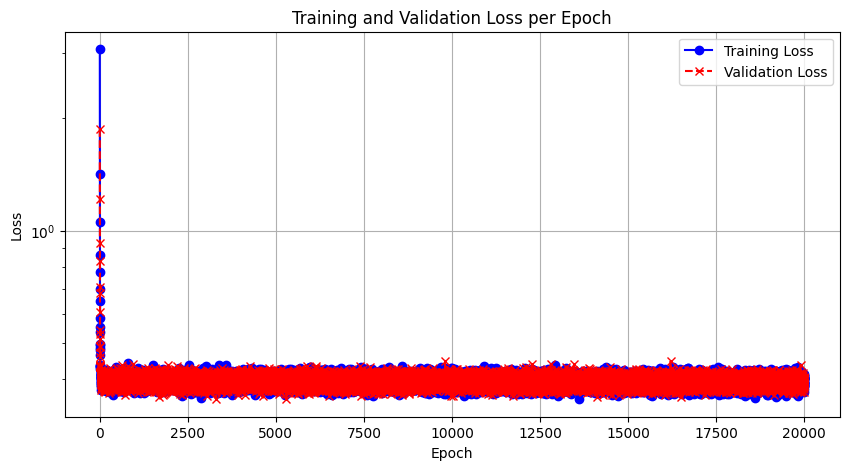

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Path to the text file
file_path = 'S3_loss21.txt'

# Read the entire file into a single string
with open(file_path, 'r') as file:
    line = file.readline().strip()

# Remove the brackets and split the string into a list of numbers
cleaned_line = line.strip('[]')
numbers = list(map(float, cleaned_line.split(',')))

# Assuming alternate entries for training and validation losses
train_losses = numbers[0::2]  # Extract even index elements: training losses
val_losses = numbers[1::2]  # Extract odd index elements: validation losses

# Epochs array based on the shorter of the two lists
epochs = np.arange(1, min(len(train_losses), len(val_losses)) + 1)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, marker='o', linestyle='-', color='blue', label='Training Loss')
plt.plot(epochs, val_losses, marker='x', linestyle='--', color='red', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()


## Stage 3 - Calculating Relative Error and Plotting Correlation Graphs

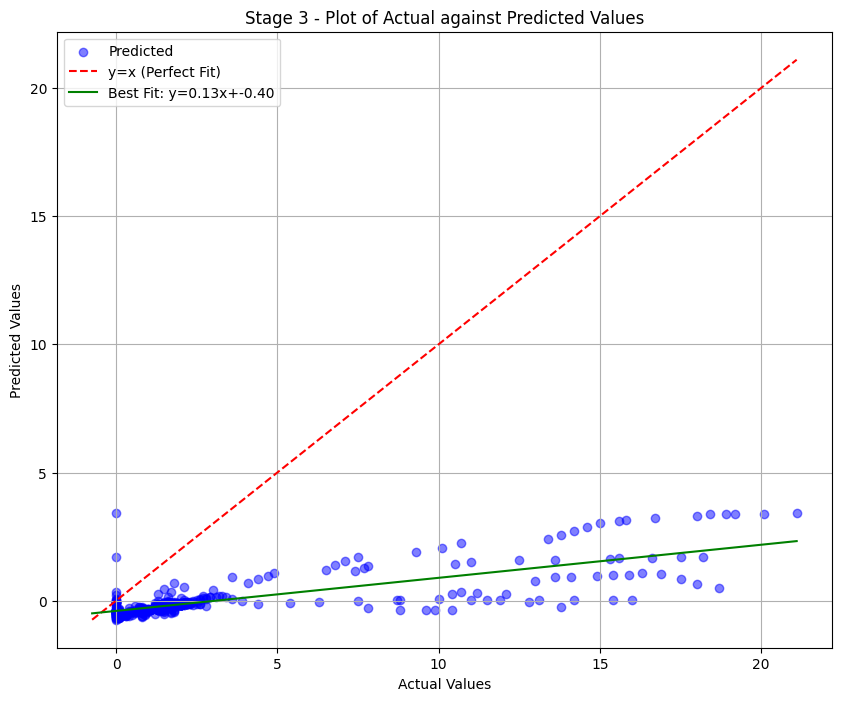

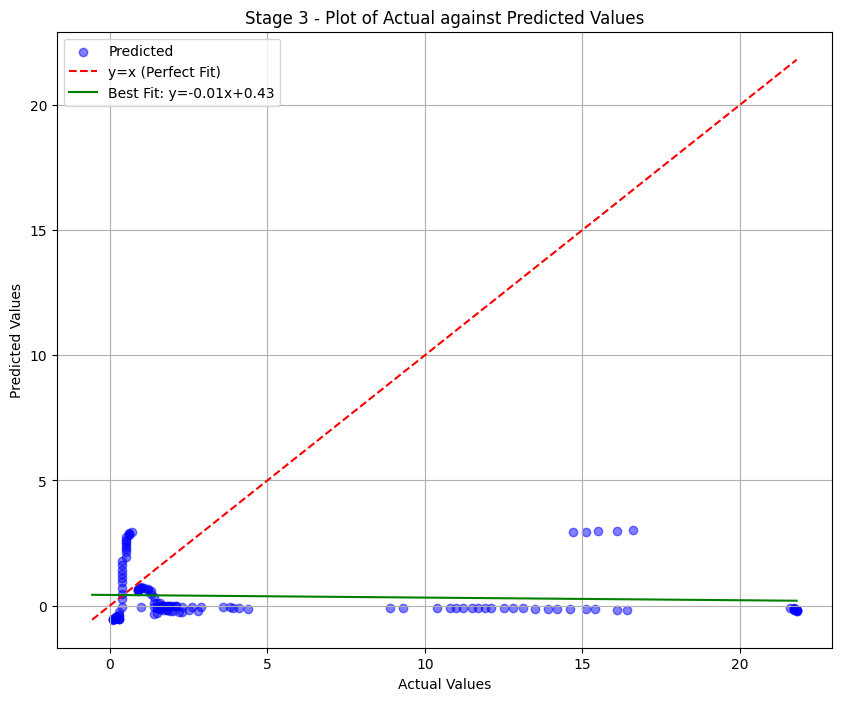

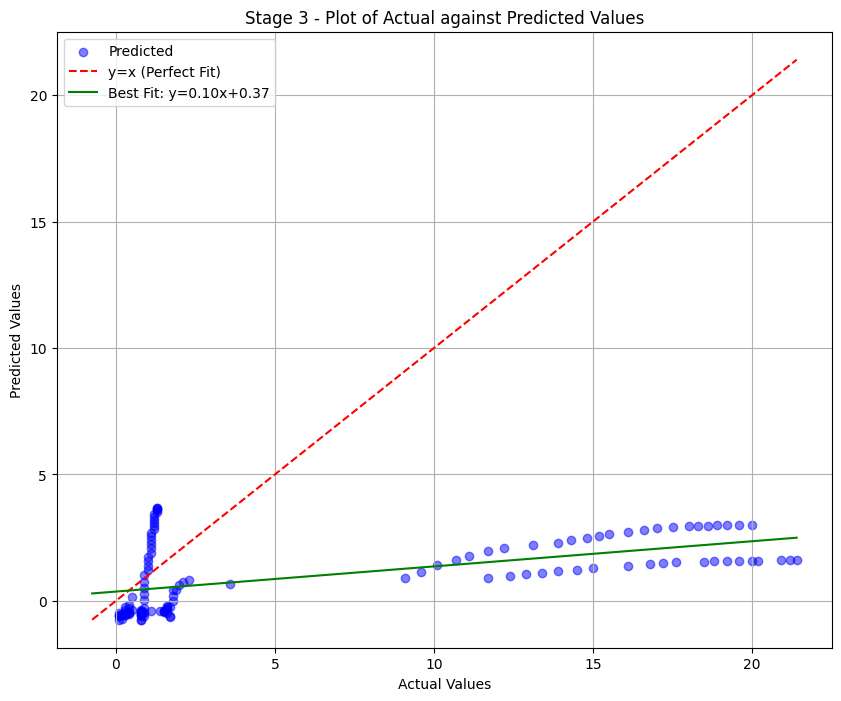

Training MSE: 5.8983, R²: 0.5758, Relative Error: 47.7711
Validation MSE: 66.4783, R²: -0.4099, Relative Error: 196.7114
Testing MSE: 40.7501, R²: 0.2501, Relative Error: 208.0834


In [3]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score, mean_squared_error
from joblib import load

# Load model and scalers
# model = YourModelClass()  # Ensure to define your model class correctly
model.load_state_dict(torch.load('S3_model21.pth'))
model.eval()

length_scaler, cptu_scaler, output_scaler = load('S3_scalers21.joblib')

def process_data(csv_file, length_scaler, cptu_scaler, output_scaler):
    data = pd.read_csv(csv_file)
    inputs = torch.tensor(length_scaler.transform(data.iloc[:, 0].values.reshape(-1, 1)), dtype=torch.float32)
    CPTu = torch.tensor(cptu_scaler.transform(data.iloc[:, 1:6163].values), dtype=torch.float32)
    targets = torch.tensor(output_scaler.transform(data.iloc[:, 6163].values.reshape(-1, 1)), dtype=torch.float32)
    return DataLoader(TensorDataset(inputs, CPTu, targets), batch_size=64, shuffle=False)

# Load your datasets
train_loader = process_data('Stage_3_traind_merged_reduced.csv', length_scaler, cptu_scaler, output_scaler)
val_loader = process_data('Stage_3_vald_merged_reduced.csv', length_scaler, cptu_scaler, output_scaler)
test_loader = process_data('Stage_3_testd_merged_reduced.csv', length_scaler, cptu_scaler, output_scaler)



def plot_actual_vs_predicted(filename, actuals, predictions, title='Actual vs. Predicted', actual_scaler=None, prediction_scaler=None):
    # If scalers are provided, inverse transform the data
    if actual_scaler is not None:
        actuals = actual_scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()
    if prediction_scaler is not None:
        predictions = prediction_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

    # Flatten arrays to ensure they are 1D
    actuals = actuals.flatten()
    predictions = predictions.flatten()

    # Create a scatter plot of actual vs predicted values
    plt.figure(figsize=(10, 8))
    plt.scatter(actuals, predictions, alpha=0.5, color='blue', label='Predicted')

    # Plot the identity line
    max_val = max(max(actuals), max(predictions))
    min_val = min(min(actuals), min(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x (Perfect Fit)')

    # Calculate the line of best fit
    coefficients = np.polyfit(actuals, predictions, 1)
    polynomial = np.poly1d(coefficients)
    trendline = polynomial(np.linspace(min_val, max_val, 100))
    plt.plot(np.linspace(min_val, max_val, 100), trendline, 'g-', label=f'Best Fit: y={coefficients[0]:.2f}x+{coefficients[1]:.2f}')

    # Add labels and legend
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Stage 3 - Plot of Actual against Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{filename}.png', dpi=300)
    plt.show()
    
    

def evaluate_model(filename, data_loader, output_scaler):
    total_mse = 0
    total_samples = 0
    preds, actuals = [], []
    relative_errors = []

    with torch.no_grad():
        for inputs, CPTu, targets in data_loader:
            outputs = model(inputs, CPTu)

            # Inverse transform the outputs and targets for MSE calculation only
            outputs_rescaled = output_scaler.inverse_transform(outputs.numpy())
            targets_rescaled = output_scaler.inverse_transform(targets.numpy())

            # Compute MSE on rescaled data
            mse = mean_squared_error(targets_rescaled, outputs_rescaled)
            total_mse += mse * inputs.size(0)
            total_samples += inputs.size(0)

            preds.append(outputs)
            actuals.append(targets)

            # Compute relative error on scaled data
            relative_error = np.abs((targets.numpy() - outputs.numpy()) / targets.numpy())
            valid_relative_error = relative_error[~np.isinf(relative_error)]
            relative_errors.extend(valid_relative_error)

    all_preds = torch.cat(preds).numpy()
    all_actuals = torch.cat(actuals).numpy()


    plot_actual_vs_predicted(filename, all_actuals, all_preds, output_scaler, output_scaler)

    # Calculate total MSE
    total_mse /= total_samples
    
    # Calculate R² score on scaled data
    r2 = r2_score(all_actuals, all_preds)

    # Calculate mean relative error on scaled data
    mean_relative_error = np.mean(relative_errors) if len(relative_errors) > 0 else np.inf

    return total_mse, r2, mean_relative_error

# Evaluate the model using separate scaling for MSE
train_mse, train_r2, train_rel_error = evaluate_model('S3_Training_data_pred_plot', train_loader, output_scaler)
val_mse, val_r2, val_rel_error = evaluate_model('S3_Validating_data_pred_plot', val_loader, output_scaler)
test_mse, test_r2, test_rel_error = evaluate_model('S3_Testing_data_pred_plot', test_loader, output_scaler)

print(f"Training MSE: {train_mse:.4f}, R²: {train_r2:.4f}, Relative Error: {train_rel_error*100:.4f}")
print(f"Validation MSE: {val_mse:.4f}, R²: {val_r2:.4f}, Relative Error: {val_rel_error*100:.4f}")
print(f"Testing MSE: {test_mse:.4f}, R²: {test_r2:.4f}, Relative Error: {test_rel_error*100:.4f}")


# To access the final model weights after evaluation:
final_weights = model.state_dict()  # This dictionary holds all weights
# You can save these weights or print t


## Plotting Traiining Set Graphs

689
16


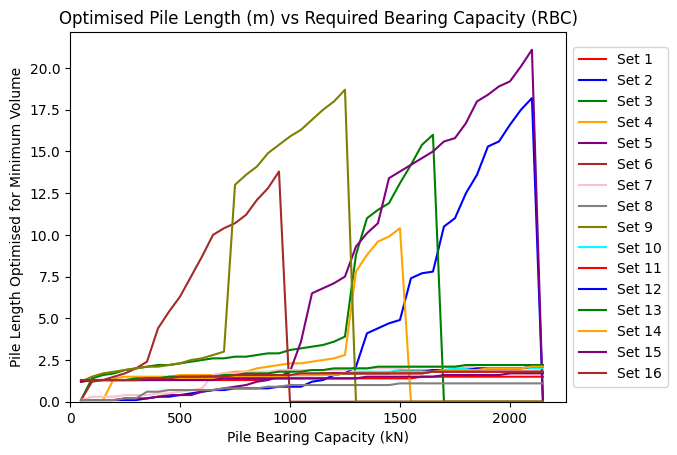

In [6]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# 
# # Load the CSV file with low_memory=False to handle mixed types better
# df = pd.read_csv('Stage_3_traind_merged_reduced.csv', header=None, low_memory=False)
# # df = pd.read_csv('Stage_3_vald_merged_reduced.csv', header=None, low_memory=False)
# # df = pd.read_csv('Stage_3_testd_merged_reduced.csv', header=None, low_memory=False)
# 
# # Convert columns to numeric, coercing errors to NaN (which won't be plotted)
# df = df.apply(pd.to_numeric, errors='coerce')
# 
# print(len(df))
# 
# import matplotlib.pyplot as plt
# 
# # Define the number of sets
# num_sets = (len(df) - 1) // 43  # Assuming this formula to calculate the number of sets
# print(num_sets)
# 
# # Colors for the plots
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
# colors = colors[:num_sets]  # Ensure the color list matches the number of sets
# 
# df['Set'] = np.arange(len(df)) % num_sets
# 
# # Plot each set
# for set_index in range(num_sets):
#     set_df = df[df['Set'] == set_index]
#     plt.plot( set_df.iloc[:, 0], set_df.iloc[:, 6163], color=colors[set_index], label=f'Set {set_index + 1}')
# 
# 
# 
# # Handling labels and legends intelligently to avoid duplicate labels
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())
# # plt.gca().invert_yaxis()
# 
# # plt.gca().xaxis.tick_top()
# # plt.gca().xaxis.set_label_position('top') 
# 
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.ylim(bottom=0)
# plt.xlim(left=0)
# plt.ylabel('Pile Length Optimised for Minimum Volume')
# plt.xlabel('Pile Bearing Capacity (kN)')
# plt.title('Optimised Pile Length (m) vs Required Bearing Capacity (RBC)')
# plt.savefig('Plot of Stage 3 - Training Data - Required Bearing Capacity vs Optimum Pile Length', dpi=300)
# 
# 
# plt.show()


## PLotting Validating and Testing Sets

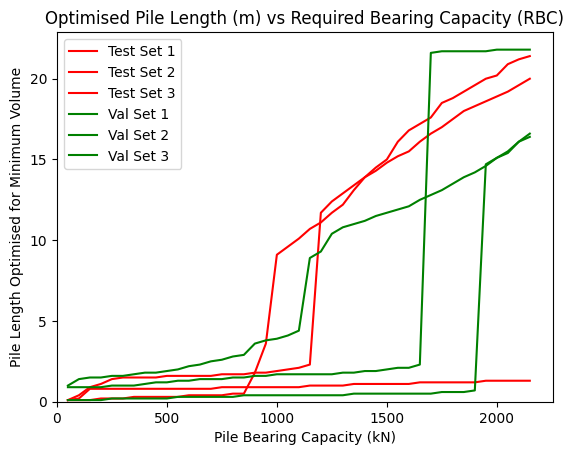

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV files
df_test = pd.read_csv('Stage_3_testd_merged_reduced.csv', header=None, low_memory=False)
df_val = pd.read_csv('Stage_3_vald_merged_reduced.csv', header=None, low_memory=False)

# Convert columns to numeric, coercing errors to NaN
df_test = df_test.apply(pd.to_numeric, errors='coerce')
df_val = df_val.apply(pd.to_numeric, errors='coerce')

# Assuming each file has similar structure and processing needs
def process_data(df):
    num_sets = (len(df) - 1) // 43  # Update the calculation if needed
    df['Set'] = np.arange(len(df)) % num_sets
    return df, num_sets

df_train, num_sets_test = process_data(df_test)
df_val, num_sets_val = process_data(df_val)

# Colors for the plots
colors_test = ['red', 'red', 'red']
colors_val = ['green', 'green', 'green']

# Plot each set from training data
for set_index in range(num_sets_test):
    set_df = df_test[df_test['Set'] == set_index]
    plt.plot(set_df.iloc[:, 0], set_df.iloc[:, 6163], color=colors_test[set_index % len(colors_test)], label=f'Test Set {set_index + 1}')

# Plot each set from validation data
for set_index in range(num_sets_val):
    set_df = df_val[df_val['Set'] == set_index]
    plt.plot(set_df.iloc[:, 0], set_df.iloc[:, 6163], color=colors_val[set_index % len(colors_val)], label=f'Val Set {set_index + 1}')

# Handling labels and legends intelligently to avoid duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.legend(loc='upper left')
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.ylabel('Pile Length Optimised for Minimum Volume')
plt.xlabel('Pile Bearing Capacity (kN)')
plt.title('Optimised Pile Length (m) vs Required Bearing Capacity (RBC)')
plt.savefig('Plot of Stage 3 - Validation and Testing Data - Required Bearing Capacity vs Optimum Pile Length', dpi=300)

plt.show()


In [16]:
# from joblib import load
# import pandas as pd
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# 
# # Loading scalers from a joblib file
# length_scaler_e, cptu_scaler_e, output_scaler_e = load('S3_scalers5.joblib')
# 
# # Load the model and device setup
# model.load_state_dict(torch.load('S3_model5.pth'))
# model.eval()
# 
# # Function to process data
# def process_data(data):
#     sets = {}
#     for i in range(len(data) // 43):
#         set_data = data.iloc[i::3, :]
#         lengths = set_data.iloc[:, 0].values.reshape(-1, 1)
#         cptu_data = set_data.iloc[:, 1:6163].values
#         outputs = set_data.iloc[:, 6163].values.reshape(-1, 1)
# 
#         # Apply scalers
#         sets[f"set{i+1}"] = {
#             "lengths": torch.tensor(length_scaler_e.transform(lengths), dtype=torch.float32),
#             "cptu": torch.tensor(cptu_scaler_e.transform(cptu_data), dtype=torch.float32),
#             "outputs": torch.tensor(output_scaler_e.transform(outputs), dtype=torch.float32)
#         }
#     return sets
# 
# # Load your data
# train_data = pd.read_csv('Stage_3_traind_merged_reduced.csv')
# val_data = pd.read_csv('Stage_3_vald_merged_reduced.csv')
# test_data = pd.read_csv('Stage_3_testd_merged_reduced.csv')
# 
# print(np.shape(train_data), len(val_data), len(test_data))
# 
# def evaluate_model(model, lengths_tensor, cptu_tensor, outputs_tensor):
#     model.eval()
#     with torch.no_grad():
#         predictions = model( cptu_tensor, lengths_tensor)
#         loss = torch.nn.functional.mse_loss(predictions, outputs_tensor).item()
#     return predictions.numpy(), outputs_tensor.numpy(), loss
# 
# print(np.shape(train_data), len(train_data))
# 
# # Process all datasets
# train_sets = process_data(train_data)
# val_sets = process_data(val_data)
# test_sets = process_data(test_data)
# 
# All_R2 = []
# 
# # Define a function to evaluate and plot results
# def evaluate_and_plot(sets, title):
#     results = {}
#     for i in range(1, len(sets) +1):
#         key = f"set{i}"
#         
#         pred, actuals, loss = evaluate_model(
#             model, 
#             sets[key]["lengths"], 
#             sets[key]["cptu"], 
#             sets[key]["outputs"]
#         )
#         results[key] = {
#             "predictions": output_scaler_e.inverse_transform(pred.reshape(-1, 1)),
#             "actuals": output_scaler_e.inverse_transform(actuals.reshape(-1, 1)),
#             "loss": loss
#         }
# 
#     # Plotting each set
#     for i, key in enumerate(results.keys()):
#         actuals = results[key]['actuals']
#         predictions = results[key]['predictions']
#        
#         # plt.figure(figsize=(10, 6))
#         # # Plot actual values
#         # plt.scatter(sets[key]["lengths"].numpy(), actuals, color='green', alpha=0.5, label='Actual Values')
#         # # Plot predicted values
#         # plt.scatter(sets[key]["lengths"].numpy(), predictions, color='red', alpha=0.5, label='Predicted Values')
#         # 
#         # plt.title(f'{title} - Actual vs Predicted Bearing Capacity')
#         # plt.xlabel('Pile Length (m)')
#         # plt.ylabel('Pile Bearing Capacity (kN)')
#         # plt.legend()
#         # plt.grid(True)
#         # plt.show()
# 
#         # Calculation of R²
#         actuals = np.array(actuals, dtype=np.float32)
#         predictions = np.array(predictions, dtype=np.float32)
#         ss_res = np.sum((actuals - predictions) ** 2)
#         ss_tot = np.sum((actuals - np.mean(actuals)) ** 2)
#         r2_value = 1 - ss_res / ss_tot
#         # print(f'R² value for {title}: {r2_value:.4f}')
#         All_R2.append(r2_value)
#         
# # Evaluate and plot for each dataset
# evaluate_and_plot(train_sets, "Training Data")
# evaluate_and_plot(val_sets, "Validation Data")
# evaluate_and_plot(test_sets, "Testing Data")
# 
# print(len(All_R2))
# 
# ## Splitting up R2 values
# Train_R2 = All_R2[:16]   # First 16 values
# Val_R2 = All_R2[16:19] # Next 3 values
# Test_R2 = All_R2[19:]    # Last 3 values
# 
# ## Plotting graph of r2 values
# Train_Bh_no = np.arange(0, 16, 1)
# Val_Bh_no = np.arange(0, 3, 1)
# Test_Bh_no = np.arange(0, 3, 1)
# 
# print('Training set mean R2 = ', np.mean(Train_R2))
# print('Validaing set mean R2 = ', np.mean(Val_R2))
# print('Testing set mean R2 = ', np.mean(Test_R2))
# 
# datasets = [
#     (Train_R2, Train_Bh_no, 'Training Set R² Values', 'blue'),
#     (Val_R2, Val_Bh_no, 'Validation Set R² Values', 'green'),
#     (Test_R2, Test_Bh_no, 'Testing Set R² Values', 'red')
# ]
# 
# # Loop through the datasets and plot each
# for data, bh_no, title, color in datasets:
#     plt.figure(figsize=(10, 6))
#     plt.plot(bh_no, data, marker='o', linestyle='-', color=color)  # 'o' for circle markers
#     plt.title(title)
#     plt.xlabel('Borehole Number')
#     plt.ylabel('R² Value')
#     plt.ylim(bottom=-1, top=1)
#     plt.grid(True)
#     plt.show()

In [17]:
# import torch
# import torch.nn.functional as F
# from torch.utils.data import DataLoader
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# 
# from joblib import load
# length_scaler, cptu_scaler, output_scaler = load('scalers.joblib')
# 
# # Load the model and device setup
# model.load_state_dict(torch.load('S3_model2.pth'))
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# model.eval()
# 
# # Assuming you have a definition for BoreholeDataset somewhere above
# # Load validation and testing data with proper scaler usage
# num_rows = len(pd.read_csv('Stage_3_vald_merged_reduced.csv'))
# 
# train_dataset_e = BoreholeDataset('Stage_3_traind_merged_reduced.csv', length_scaler, cptu_scaler, output_scaler, fit_scalers=False)
# train_loader_e = DataLoader(train_dataset_e, batch_size=num_rows, shuffle=False)
# 
# val_dataset_e = BoreholeDataset('Stage_3_vald_merged_reduced.csv', length_scaler, cptu_scaler, output_scaler, fit_scalers=False)
# val_loader_e = DataLoader(val_dataset_e, batch_size=num_rows, shuffle=False)
# 
# test_dataset_e = BoreholeDataset('Stage_3_testd_merged_reduced.csv', length_scaler, cptu_scaler, output_scaler, fit_scalers=False)
# test_loader_e = DataLoader(test_dataset_e, batch_size=num_rows, shuffle=False)
# 
# 
# 
# def evaluate_model(model, loader, device):
#     model.to(device)
#     model.eval()
#     predictions = {f'Borehole {i+1}': [] for i in range(3)}
#     targets = {f'Borehole {i+1}': [] for i in range(3)}
#     
#     with torch.no_grad():
#         for lengths, cptu_data, outputs in loader:
#             lengths, cptu_data, outputs = lengths.to(device), cptu_data.to(device), outputs.to(device)
#             predicted_outputs = model(cptu_data, lengths)
#             for i in range(len(outputs)):
#                 borehole_id = (i % 3) + 1  # Calculate borehole ID based on index
#                 predictions[f'Borehole {borehole_id}'].append(predicted_outputs[i].detach())
#                 targets[f'Borehole {borehole_id}'].append(outputs[i].detach())
# 
#     metrics = {}
#     for i in range(3):
#         bh_id = f'Borehole {i+1}'
#         pred_tensor = torch.stack(predictions[bh_id])
#         target_tensor = torch.stack(targets[bh_id])
#         pred_tensor_np = pred_tensor.cpu().numpy()
#         target_tensor_np = target_tensor.cpu().numpy()
#         
#         ase = F.mse_loss(pred_tensor, target_tensor).item()
#         rmse = np.sqrt(ase)
#         mare = np.mean(np.abs((target_tensor_np - pred_tensor_np) / (target_tensor_np + 1e-8)))
#         r2 = 1 - np.sum((target_tensor_np - pred_tensor_np) ** 2) / np.sum((target_tensor_np - np.mean(target_tensor_np)) ** 2)
# 
#         metrics[bh_id] = {
#             'RMSE': rmse,
#             'ASE': ase,
#             'MARE': mare,
#             'R^2': r2
#         }
#     return metrics
# 
# 
# 
# # Calculate and print averages of metrics across all boreholes
# metrics = evaluate_model(model, train_loader, device)
# 
# 
# 
# average_metrics = {key: np.mean([metrics[bh][key] for bh in metrics]) for key in metrics['Borehole 1']}
# for metric, value in average_metrics.items():
#     print(f"Average {metric}: {value:.3f}")
#     
# 
# def plot_metrics(metrics):
#     fig, ax = plt.subplots(figsize=(10, 6))
#     metrics_list = ['RMSE', 'ASE', 'MARE', 'R^2']
#     colors = ['green', 'red', 'purple', 'orange']
#     boreholes = ['Borehole 1', 'Borehole 2', 'Borehole 3']
#     x = np.arange(len(boreholes))
# 
#     for idx, metric in enumerate(metrics_list):
#         values = [metrics[bh][metric] for bh in boreholes]
#         ax.plot(x, values, marker='o', color=colors[idx], label=metric)
# 
#     ax.set_xlabel('Borehole Number')
#     ax.set_ylabel('Correlation Value')
#     ax.set_title('Plot of Correlation Values against Borehole Number')
#     ax.set_xticks(x)
#     ax.set_xticklabels(boreholes)
#     ax.legend()
#     ax.set_yscale('symlog', linthresh=0.1, linscale=0.1)
#     ax.set_ylim(bottom=-1, top=10)
#     plt.grid(True)
#     plt.show()
# 
# 
# plot_metrics(metrics)


In [18]:
# ## Checking Against Validating data
# metrics = evaluate_model(model, val_loader, device)
# 
# average_metrics = {key: np.mean([metrics[bh][key] for bh in metrics]) for key in metrics['Borehole 1']}
# for metric, value in average_metrics.items():
#     print(f"Average {metric}: {value:.3f}")
#     
# plot_metrics(metrics)

In [19]:
# ## Checking Against Validating data
# metrics = evaluate_model(model, test_loader, device)
# 
# average_metrics = {key: np.mean([metrics[bh][key] for bh in metrics]) for key in metrics['Borehole 1']}
# for metric, value in average_metrics.items():
#     print(f"Average {metric}: {value:.3f}")
#     
# plot_metrics(metrics)